# **[Chapter 11]**  
**┗ 전력사용 이상 사용 패턴 탐지**
---
> **목차(Context)**

* 문제상황 및 데이터 살펴보기
* 문제해결 프로세스 정의
* 🥉Session 1 - 「Data 전처리 및 EDA」
* 🥈Session 2 - 「주중 vs 주말 전력사용 분석」
* 🥇Session 3 - 「이상 탐지 모델링」

In [ ]:
# ▶ Warnings 제거
import warnings
warnings.filterwarnings('ignore')

# ▶ Google drive mount or 폴더 클릭 후 구글드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

# ▶ 경로 설정 (※ Colab을 활성화시켰다면 보통 Colab Notebooks 폴더가 자동 생성)
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/Anomaly Detection (FC)/Step 3. 도메인별 이상탐지 실습/[02] Chapter 11. 전력사용 이상 사용 패턴 탐지")
os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/Colab Notebooks/Anomaly Detection (FC)/Step 3. 도메인별 이상탐지 실습/[02] Chapter 11. 전력사용 이상 사용 패턴 탐지'

## **문제상황 및 데이터 살펴보기**
---
> **시나리오** 💡⚡
```
A사는 이번에 큰 투자비용을 들여 스마트빌딩을 구축했다. 스마트빌딩은 BEMS 시스템 즉 Building Energy Management System이  
구축되어 있어 에너지 자원을 효율적으로 사용할 수 있으며, 사용되는 에너지의 데이터를 모니터링 할 수 있는 장점을 가지고 있다.  
BEMS를 활용하여 전력사용 데이터를 활용하여 이상 탐지 모델링을 수행하고, 전력 사용을 효율적으로 이용하고자 한다.
```  

> **데이터 살펴보기**

* 스마트빌딩 전력사용 데이터
* 데이터 명세 ⬇ 

|Column|Description|
|:---|:---|
|date|날짜|
|Floor(n)_z(n)_val| 층/Zone/전기사용제품|



In [ ]:
df.shape

(790560, 192)

In [ ]:
# ▶ pd.set option
import pandas as pd 
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)  

df = pd.read_pickle('chapter11_df.gz')
df.head()

,Floor1_z1_Light(kW),Floor1_z1_Plug(kW),Floor1_z2_AC1(kW),Floor1_z2_AC2(kW),Floor1_z2_AC3(kW),Floor1_z2_AC4(kW),Floor1_z2_Light(kW),Floor1_z2_Plug(kW),Floor1_z3_Light(kW),Floor1_z3_Plug(kW),Floor1_z4_Light(kW),Floor2_z1_AC1(kW),Floor2_z1_Light(kW),Floor2_z1_Plug(kW),Floor2_z1_S1(RH%),Floor2_z1_S1(degC),Floor2_z1_S1(lux),Floor2_z2_AC1(kW),Floor2_z2_AC10(kW),Floor2_z2_AC11(kW),Floor2_z2_AC12(kW),Floor2_z2_AC13(kW),Floor2_z2_AC14(kW),Floor2_z2_AC2(kW),Floor2_z2_AC3(kW),Floor2_z2_AC4(kW),Floor2_z2_AC5(kW),Floor2_z2_AC6(kW),Floor2_z2_AC7(kW),Floor2_z2_AC8(kW),Floor2_z2_AC9(kW),Floor2_z2_Light(kW),Floor2_z2_Plug(kW),Floor2_z2_S1(RH%),Floor2_z2_S1(degC),Floor2_z2_S1(lux),Floor2_z3_Light(kW),Floor2_z3_Plug(kW),Floor2_z3_S1(RH%),Floor2_z3_S1(degC),Floor2_z3_S1(lux),Floor2_z4_AC1(kW),Floor2_z4_Light(kW),Floor2_z4_Plug(kW),Floor2_z4_S1(RH%),Floor2_z4_S1(degC),Floor2_z4_S1(lux),Floor3_z1_AC1(kW),Floor3_z1_AC2(kW),Floor3_z1_AC3(kW),...,Floor6_z2_Plug(kW),Floor6_z2_S1(RH%),Floor6_z2_S1(degC),Floor6_z2_S1(lux),Floor6_z3_Light(kW),Floor6_z3_Plug(kW),Floor6_z4_AC1(kW),Floor6_z4_AC2(kW),Floor6_z4_AC3(kW),Floor6_z4_AC4(kW),Floor6_z4_Light(kW),Floor6_z4_Plug(kW),Floor6_z4_S1(RH%),Floor6_z4_S1(degC),Floor6_z4_S1(lux),Floor6_z5_AC1(kW),Floor6_z5_Light(kW),Floor6_z5_Plug(kW),Floor6_z5_S1(RH%),Floor6_z5_S1(degC),Floor6_z5_S1(lux),Floor7_z1_AC1(kW),Floor7_z1_AC2(kW),Floor7_z1_AC3(kW),Floor7_z1_AC4(kW),Floor7_z1_Light(kW),Floor7_z1_Plug(kW),Floor7_z1_S1(RH%),Floor7_z1_S1(degC),Floor7_z1_S1(lux),Floor7_z2_AC1(kW),Floor7_z2_Light(kW),Floor7_z2_Plug(kW),Floor7_z2_S1(RH%),Floor7_z2_S1(degC),Floor7_z2_S1(lux),Floor7_z3_Light(kW),Floor7_z3_Plug(kW),Floor7_z4_AC1(kW),Floor7_z4_Light(kW),Floor7_z4_Plug(kW),Floor7_z4_S1(RH%),Floor7_z4_S1(degC),Floor7_z4_S1(lux),Floor7_z5_AC1(kW),Floor7_z5_Light(kW),Floor7_z5_Plug(kW),Floor7_z5_S1(RH%),Floor7_z5_S1(degC),Floor7_z5_S1(lux)
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-07-01 00:00:00,12.94,18.56,45.24,0.01,0.01,0.00,13.76,17.64,10.92,0.89,35.76,0.0,0.01,0.15,58.93,28.36,0.0,1.08,1.07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.29,1.26,0.87,0.92,0.96,0.0,0.10,64.89,28.85,0.0,0.01,0.32,68.22,29.30,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,...,0.13,70.56,27.79,0.0,0.02,0.27,0.0,0.0,0.0,0.0,0.0,0.07,71.76,27.28,0.0,0.0,0.0,0.01,68.48,28.9,0.0,0.0,0.0,0.01,0.0,0.0,0.02,64.42,28.23,0.0,0.0,0.0,0.0,66.24,28.57,0.0,0.02,0.18,0.0,0.21,0.0,65.16,29.4,0.0,0.0,0.0,0.03,66.72,28.93,0.0
2018-07-01 00:01:00,12.97,18.55,45.28,0.02,0.01,0.01,13.76,17.21,10.95,0.87,35.81,0.0,0.01,0.15,58.91,28.36,0.0,1.07,1.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.30,1.24,0.88,0.91,0.97,0.0,0.10,64.89,28.85,0.0,0.01,0.32,68.21,29.30,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,...,0.13,70.56,27.78,0.0,0.02,0.27,0.0,0.0,0.0,0.0,0.0,0.06,71.76,27.28,0.0,0.0,0.0,0.01,68.48,28.9,0.0,0.0,0.0,0.01,0.0,0.0,0.02,64.42,28.23,0.0,0.0,0.0,0.0,66.26,28.56,0.0,0.02,0.15,0.0,0.18,0.0,65.17,29.3,0.0,0.0,0.0,0.03,66.70,28.92,0.0
2018-07-01 00:02:00,12.97,18.55,45.24,0.01,0.01,0.01,13.79,17.18,10.94,0.86,35.78,0.0,0.01,0.15,58.94,28.36,0.0,0.88,0.88,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.09,1.03,0.74,0.75,0.82,0.0,0.09,64.89,28.85,0.0,0.01,0.28,68.24,29.29,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,...,0.13,70.56,27.77,0.0,0.02,0.27,0.0,0.0,0.0,0.0,0.0,0.11,71.76,27.28,0.0,0.0,0.0,0.01,68.50,28.9,0.0,0.0,0.0,0.01,0.0,0.0,0.02,64.42,28.23,0.0,0.0,0.0,0.0,66.28,28.56,0.0,0.02,0.21,0.0,0.21,0.0,65.18,29.3,0.0,0.0,0.0,0.05,66.70,28.92,0.0
2018-07-01 00:03:00,12.98,18.58,45.26,0.02,0.01,0.00,13.81,16.64,10.94,0.85,35.83,0.0,0.01,0.15,58.94,28.36,0.0,1.06,1.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.29,1.23,0.87,0.90,0.96,0.0,0.09,64.89,28.85,0.0,0.01,0.32,68.28,29.29,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,...,0.13,70.57,27.77,0.0,0.02,0.27,0.0,0.0,0.0,0.0,0.0,0.22,71.76,27.27,0.0,0.0,0.0,0.01,68.51,28.9,0.0,0.0,0.0,0.01,0.0,0.0,0.02,64.42,28.23,0.0,0.0,0.0,0.0,66.29,28.56,0.0,0.02,0.18,0.0,0.25,0.0,65.18,29.3,0.0,0.0,0.0,0.14,66.70,28.92,0.0
2018-07-01 00


## **문제해결 프로세스 정의**
---
> **문제정의**

```
▶ 스마트 빌딩 전력 비효율적 사용 (비정상적으로 많이 사용하는 포인트가 존재. limit 없음)
▶ 전력 비효율적 사용으로 인한 에너지 낭비
```  

> **기대효과**

```
▶ 전력 사용 이상 패턴 탐지하여 limit 부여로 효율적 전력 사용
▶ 에너지 소비 감소, 에너지 비용 절감
```

> **해결방안**

```
▶ 전력 사용 이상 패턴 탐지하는 이상 탐지 모델링 
▶ Session 1 🥉
 - Data 전처리 및 EDA
▶ Session 2 🥈
 - 주중 vs 주말 전력 사용 패턴 분석
▶ Session 3 🥇
 - 이상 탐지 모델링 수행 
```

> **성과측정**  

```
▶ 모델 활용 전/후 전력 사용량 모니터링
▶ 모델 활용 전/후 에너지 소비 금액 비교
```

> **현업적용**  

```
▶ BEMS에서 전력 사용량 데이터 수집 
▶ 전력 사용 데이터 이상 탐지 모델에 Input
▶ 이상점 탐지 및 Alarm
```

> **주요 코드 미리 살펴보기**  

```
▶ Session 1 → read_pickle(), .str.contains(), .resample('H').mean()
▶ Session 2 → df['Date'].dt.weekday, sns.distplot(), .pivot_table()
▶ Session 3 → transpose(), Counter()
```

## **🥉Session 1**  
**┗ Data 전처리 및 EDA**  
---

### · Data 전처리  
---
* 수집된 데이터의 기본 정보들을 확인  

  (1) Data shape(형태) 확인 

  (2) Data type 확인

  (3) Null값 확인 (※ 빈 값의 Data)

  (4) Outlier 확인 (※ 정상적인 범주를 벗어난 Data)  

In [ ]:
# ▶ Data 형태 확인
# ▶ 790560 row, 192 col로 구성됨
print('df :', df.shape)

df : (790560, 192)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 790560 entries, 2018-07-01 00:00:00 to 2019-12-31 23:59:00
Columns: 192 entries, Floor1_z1_Light(kW) to Floor7_z5_S1(lux)
dtypes: float64(192)
memory usage: 1.1 GB


In [ ]:
# ▶ Data type 확인
df.iloc[:,0:20].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 790560 entries, 2018-07-01 00:00:00 to 2019-12-31 23:59:00
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Floor1_z1_Light(kW)  788169 non-null  float64
 1   Floor1_z1_Plug(kW)   789459 non-null  float64
 2   Floor1_z2_AC1(kW)    788231 non-null  float64
 3   Floor1_z2_AC2(kW)    788355 non-null  float64
 4   Floor1_z2_AC3(kW)    788354 non-null  float64
 5   Floor1_z2_AC4(kW)    788354 non-null  float64
 6   Floor1_z2_Light(kW)  788516 non-null  float64
 7   Floor1_z2_Plug(kW)   760031 non-null  float64
 8   Floor1_z3_Light(kW)  789447 non-null  float64
 9   Floor1_z3_Plug(kW)   788355 non-null  float64
 10  Floor1_z4_Light(kW)  789433 non-null  float64
 11  Floor2_z1_AC1(kW)    760318 non-null  float64
 12  Floor2_z1_Light(kW)  789492 non-null  float64
 13  Floor2_z1_Plug(kW)   789487 non-null  float64
 14  Floor2_z1_S1(RH%)    515922 non-nu

In [ ]:
# ▶ Null 값 확인
print(df.isnull().sum())

Floor1_z1_Light(kW)      2391
Floor1_z1_Plug(kW)       1101
Floor1_z2_AC1(kW)        2329
Floor1_z2_AC2(kW)        2205
Floor1_z2_AC3(kW)        2206
                        ...  
Floor7_z5_Light(kW)      4525
Floor7_z5_Plug(kW)       4849
Floor7_z5_S1(RH%)      281766
Floor7_z5_S1(degC)     281766
Floor7_z5_S1(lux)      281767
Length: 192, dtype: int64


In [ ]:
# ▶ Null 값 데이터 출력
df[df.isnull()].head()

,Floor1_z1_Light(kW),Floor1_z1_Plug(kW),Floor1_z2_AC1(kW),Floor1_z2_AC2(kW),Floor1_z2_AC3(kW),Floor1_z2_AC4(kW),Floor1_z2_Light(kW),Floor1_z2_Plug(kW),Floor1_z3_Light(kW),Floor1_z3_Plug(kW),Floor1_z4_Light(kW),Floor2_z1_AC1(kW),Floor2_z1_Light(kW),Floor2_z1_Plug(kW),Floor2_z1_S1(RH%),Floor2_z1_S1(degC),Floor2_z1_S1(lux),Floor2_z2_AC1(kW),Floor2_z2_AC10(kW),Floor2_z2_AC11(kW),Floor2_z2_AC12(kW),Floor2_z2_AC13(kW),Floor2_z2_AC14(kW),Floor2_z2_AC2(kW),Floor2_z2_AC3(kW),Floor2_z2_AC4(kW),Floor2_z2_AC5(kW),Floor2_z2_AC6(kW),Floor2_z2_AC7(kW),Floor2_z2_AC8(kW),Floor2_z2_AC9(kW),Floor2_z2_Light(kW),Floor2_z2_Plug(kW),Floor2_z2_S1(RH%),Floor2_z2_S1(degC),Floor2_z2_S1(lux),Floor2_z3_Light(kW),Floor2_z3_Plug(kW),Floor2_z3_S1(RH%),Floor2_z3_S1(degC),Floor2_z3_S1(lux),Floor2_z4_AC1(kW),Floor2_z4_Light(kW),Floor2_z4_Plug(kW),Floor2_z4_S1(RH%),Floor2_z4_S1(degC),Floor2_z4_S1(lux),Floor3_z1_AC1(kW),Floor3_z1_AC2(kW),Floor3_z1_AC3(kW),...,Floor6_z2_Plug(kW),Floor6_z2_S1(RH%),Floor6_z2_S1(degC),Floor6_z2_S1(lux),Floor6_z3_Light(kW),Floor6_z3_Plug(kW),Floor6_z4_AC1(kW),Floor6_z4_AC2(kW),Floor6_z4_AC3(kW),Floor6_z4_AC4(kW),Floor6_z4_Light(kW),Floor6_z4_Plug(kW),Floor6_z4_S1(RH%),Floor6_z4_S1(degC),Floor6_z4_S1(lux),Floor6_z5_AC1(kW),Floor6_z5_Light(kW),Floor6_z5_Plug(kW),Floor6_z5_S1(RH%),Floor6_z5_S1(degC),Floor6_z5_S1(lux),Floor7_z1_AC1(kW),Floor7_z1_AC2(kW),Floor7_z1_AC3(kW),Floor7_z1_AC4(kW),Floor7_z1_Light(kW),Floor7_z1_Plug(kW),Floor7_z1_S1(RH%),Floor7_z1_S1(degC),Floor7_z1_S1(lux),Floor7_z2_AC1(kW),Floor7_z2_Light(kW),Floor7_z2_Plug(kW),Floor7_z2_S1(RH%),Floor7_z2_S1(degC),Floor7_z2_S1(lux),Floor7_z3_Light(kW),Floor7_z3_Plug(kW),Floor7_z4_AC1(kW),Floor7_z4_Light(kW),Floor7_z4_Plug(kW),Floor7_z4_S1(RH%),Floor7_z4_S1(degC),Floor7_z4_S1(lux),Floor7_z5_AC1(kW),Floor7_z5_Light(kW),Floor7_z5_Plug(kW),Floor7_z5_S1(RH%),Floor7_z5_S1(degC),Floor7_z5_S1(lux)
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-07-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-01 00:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-01 00:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-01 00:03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-01 00:04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [ ]:
# ▶ Outlier 확인
df.describe()

,Floor1_z1_Light(kW),Floor1_z1_Plug(kW),Floor1_z2_AC1(kW),Floor1_z2_AC2(kW),Floor1_z2_AC3(kW),Floor1_z2_AC4(kW),Floor1_z2_Light(kW),Floor1_z2_Plug(kW),Floor1_z3_Light(kW),Floor1_z3_Plug(kW),Floor1_z4_Light(kW),Floor2_z1_AC1(kW),Floor2_z1_Light(kW),Floor2_z1_Plug(kW),Floor2_z1_S1(RH%),Floor2_z1_S1(degC),Floor2_z1_S1(lux),Floor2_z2_AC1(kW),Floor2_z2_AC10(kW),Floor2_z2_AC11(kW),Floor2_z2_AC12(kW),Floor2_z2_AC13(kW),Floor2_z2_AC14(kW),Floor2_z2_AC2(kW),Floor2_z2_AC3(kW),Floor2_z2_AC4(kW),Floor2_z2_AC5(kW),Floor2_z2_AC6(kW),Floor2_z2_AC7(kW),Floor2_z2_AC8(kW),Floor2_z2_AC9(kW),Floor2_z2_Light(kW),Floor2_z2_Plug(kW),Floor2_z2_S1(RH%),Floor2_z2_S1(degC),Floor2_z2_S1(lux),Floor2_z3_Light(kW),Floor2_z3_Plug(kW),Floor2_z3_S1(RH%),Floor2_z3_S1(degC),Floor2_z3_S1(lux),Floor2_z4_AC1(kW),Floor2_z4_Light(kW),Floor2_z4_Plug(kW),Floor2_z4_S1(RH%),Floor2_z4_S1(degC),Floor2_z4_S1(lux),Floor3_z1_AC1(kW),Floor3_z1_AC2(kW),Floor3_z1_AC3(kW),...,Floor6_z2_Plug(kW),Floor6_z2_S1(RH%),Floor6_z2_S1(degC),Floor6_z2_S1(lux),Floor6_z3_Light(kW),Floor6_z3_Plug(kW),Floor6_z4_AC1(kW),Floor6_z4_AC2(kW),Floor6_z4_AC3(kW),Floor6_z4_AC4(kW),Floor6_z4_Light(kW),Floor6_z4_Plug(kW),Floor6_z4_S1(RH%),Floor6_z4_S1(degC),Floor6_z4_S1(lux),Floor6_z5_AC1(kW),Floor6_z5_Light(kW),Floor6_z5_Plug(kW),Floor6_z5_S1(RH%),Floor6_z5_S1(degC),Floor6_z5_S1(lux),Floor7_z1_AC1(kW),Floor7_z1_AC2(kW),Floor7_z1_AC3(kW),Floor7_z1_AC4(kW),Floor7_z1_Light(kW),Floor7_z1_Plug(kW),Floor7_z1_S1(RH%),Floor7_z1_S1(degC),Floor7_z1_S1(lux),Floor7_z2_AC1(kW),Floor7_z2_Light(kW),Floor7_z2_Plug(kW),Floor7_z2_S1(RH%),Floor7_z2_S1(degC),Floor7_z2_S1(lux),Floor7_z3_Light(kW),Floor7_z3_Plug(kW),Floor7_z4_AC1(kW),Floor7_z4_Light(kW),Floor7_z4_Plug(kW),Floor7_z4_S1(RH%),Floor7_z4_S1(degC),Floor7_z4_S1(lux),Floor7_z5_AC1(kW),Floor7_z5_Light(kW),Floor7_z5_Plug(kW),Floor7_z5_S1(RH%),Floor7_z5_S1(degC),Floor7_z5_S1(lux)
count,788169.000000,789459.000000,788231.000000,788355.000000,788354.000000,788354.000000,788516.000000,760031.000000,789447.000000,788355.000000,789433.000000,760318.000000,789492.000000,789487.000000,515922.000000,515922.000000,515922.000000,760084.000000,789417.000000,789417.0,789417.000000,789417.000000,789417.000000,787961.000000,787961.000000,787961.000000,789417.000000,789417.000000,789417.000000,789417.000000,789417.000000,789386.000000,789338.000000,530254.000000,530251.000000,530252.000000,789489.000000,789490.000000,525741.000000,525740.000000,525737.000000,760249.000000,787961.000000,789338.000000,422317.000000,422315.000000,422312.000000,719633.000000,719633.000000,719633.000000,...,688095.000000,398223.000000,398223.000000,398223.000000,688105.000000,688092.000000,686202.000000,686202.000000,686202.000000,688048.000000,687072.000000,688094.000000,430727.000000,430726.000000,430727.000000,688023.000000,686451.000000,687072.000000,426139.000000,426146.000000,426146.000000,785711.0,785711.000000,785711.000000,760272.000000,787562.000000,789351.000000,525332.000000,525330.000000,525275.000000,760268.000000,787562.000000,787214.000000,529566.000000,529567.000000,529563.000000,788364.000000,786896.000000,760286.000000,782703.000000,785711.000000,520547.000000,520548.000000,520544.000000,760292.000000,786035.000000,785711.000000,508794.000000,508794.000000,508793.000000
mean,6.374115,2.431081,28.044690,5.098173,0.008349,0.007349,10.326638,15.128056,21.823732,1.202470,16.432264,8.537406,2.706336,1.107082,61.536675,24.700101,27.906689,6.079580,0.414307,0.0,0.007018,0.043787,0.007122,0.628142,0.421450,0.471542,0.978702,0.586040,0.654046,0.362112,0.727240,0.628621,0.179655,65.020223,25.461552,16.402222,0.524215,0.328631,65.006414,27.590986,2.681126,2.365327,0.596903,0.017949,72.856257,23.548124,13.459210,0.002222,0.006714,0.007167,...,0.394684,63.121235,25.379942,25.143113,0.907454,0.268794,0.002827,0.017710,0.002941,3.670580,1.438686,0.368627,62.593711,25.401429,13.793428,1.395081,0.825058,0.176628,63.967024,25.712094,18.050964,0.0,0.061161,0.063215,8.468760,0.799035,0.186694,66.448911,24.7

In [ ]:
# ▶ Leave columns with keyword of 'kW' (전력량에 해당하는 값만 보고자 함)
df_powerMeter = df.loc[:, df.columns.str.contains('kW')].copy()

# ▶ Sum up demands of all power meters
# ▶ mean(), std() 연산 시 : NaN은 분석 대상(population)에서 제외
df_powerMeter = df_powerMeter.sum(axis=1).rename('total_demand')

In [88]:
df_powerMeter.head()

Date
2018-07-01 00:00:00    176.261667
2018-07-01 01:00:00    177.300000
2018-07-01 02:00:00    177.048833
2018-07-01 03:00:00    175.129167
2018-07-01 04:00:00    183.175000
Freq: H, Name: total_demand, dtype: float64

In [ ]:
df_powerMeter = df_powerMeter.resample('H').mean() # 1시간 단위의 평균전력량 계산
df = pd.DataFrame(df_powerMeter)
df.head()

,total_demand
Date,
2018-07-01 00:00:00,176.261667
2018-07-01 01:00:00,177.300000
2018-07-01 02:00:00,177.048833
2018-07-01 03:00:00,175.129167
2018-07-01 04:00:00,183.175000


### · Data EDA
---
* 데이터 특성 파악을 위한 초기 탐색

In [ ]:
# ▶ 필요 없는 변수 사전 제거 
df.head()

,total_demand
Date,
2018-07-01 00:00:00,176.261667
2018-07-01 01:00:00,177.300000
2018-07-01 02:00:00,177.048833
2018-07-01 03:00:00,175.129167
2018-07-01 04:00:00,183.175000


In [ ]:
df.isnull().sum()

total_demand    0
dtype: int64

In [ ]:
df.index.min(), df.index.max()

(Timestamp('2018-07-01 00:00:00', freq='H'),
 Timestamp('2019-12-31 23:00:00', freq='H'))

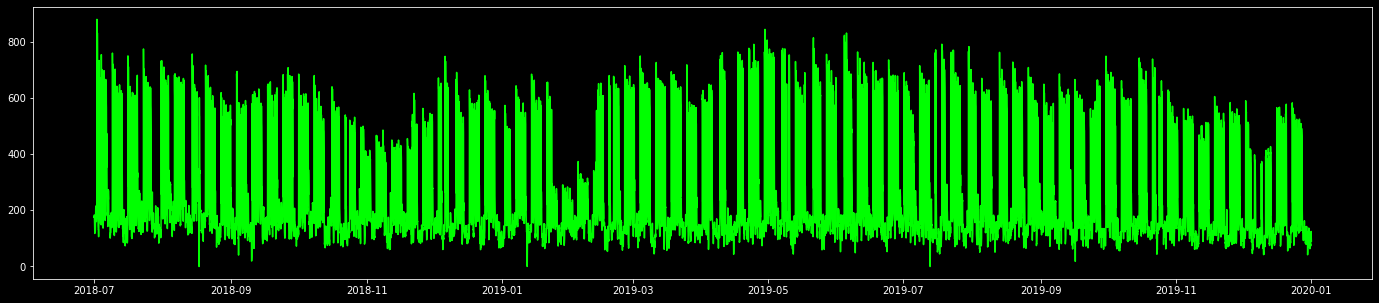

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['dark_background'])

plt.figure(figsize=(24,5))
plt.plot(df.index, df['total_demand'], linestyle='-', color='lime'); ## 전체 데이터 >> 뭔가 일정한 패턴이 있어 보임

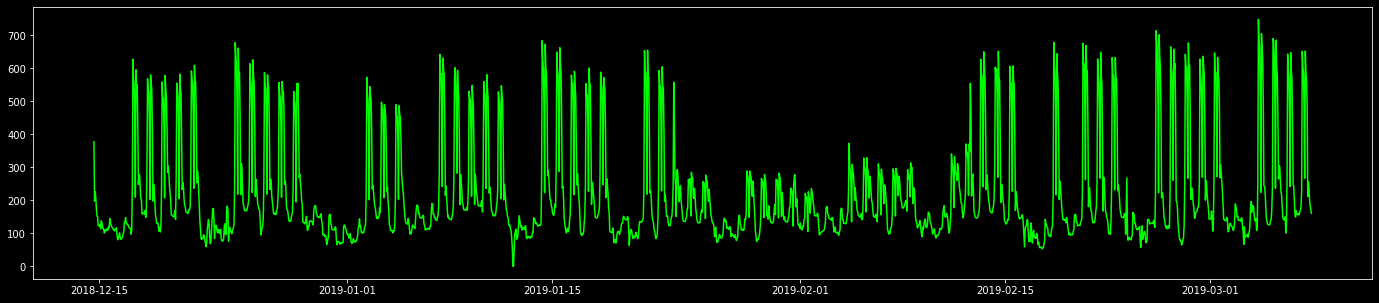

In [ ]:
plt.figure(figsize=(24,5)) # 중간에 비어있는(19년2월경) 데이터를 자세히 확인 
plt.plot(df.index[4000:6000], df['total_demand'][4000:6000], linestyle='-', color='lime');

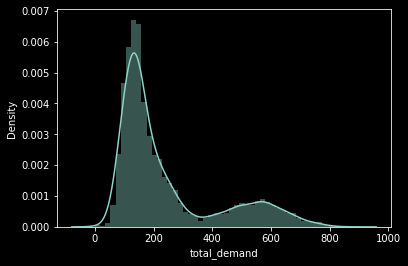

In [ ]:
# ▶ 분포 확인 >> 봉우리가 2개. 혹시 주중/주말?
sns.distplot(df['total_demand']);

In [ ]:
# ▶ 기술통계량 확인
df['total_demand'].describe()

count    13176.000000
mean       241.545518
std        174.861629
min          0.000000
25%        124.390667
50%        163.905583
75%        278.471375
max        879.319167
Name: total_demand, dtype: float64

## **🥈Session 2**  
**┗ 주중 vs 주말 전력사용 분석**  
---

### · 주말, 주중 col 생성
---

* 왜 주중/주말? 
- 빌딩 특성에 따라 사용패턴이 다를 것
- 오피스는 주중이 많을 것이고, 쇼핑몰은 주말이 많을 것이고...
- 나눠서 확인해보기로 

In [ ]:
df.head()

,total_demand
Date,
2018-07-01 00:00:00,176.261667
2018-07-01 01:00:00,177.300000
2018-07-01 02:00:00,177.048833
2018-07-01 03:00:00,175.129167
2018-07-01 04:00:00,183.175000


In [ ]:
# ▶ Date col 활용하기 위해 reset index
df = df.reset_index()
df.head()

,Date,total_demand
0,2018-07-01 00:00:00,176.261667
1,2018-07-01 01:00:00,177.300000
2,2018-07-01 02:00:00,177.048833
3,2018-07-01 03:00:00,175.129167
4,2018-07-01 04:00:00,183.175000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13176 entries, 0 to 13175
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          13176 non-null  datetime64[ns]
 1   total_demand  13176 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 206.0 KB


In [ ]:
# ▶ .weekday()
# ▶ 0-월, 1-화, 2-수, 3-목, 4-금, 5-토, 6-일
df['weekday'] = df['Date'].dt.weekday
df.head()

,Date,total_demand,weekday
0,2018-07-01 00:00:00,176.261667,6
1,2018-07-01 01:00:00,177.300000,6
2,2018-07-01 02:00:00,177.048833,6
3,2018-07-01 03:00:00,175.129167,6
4,2018-07-01 04:00:00,183.175000,6


In [ ]:
# ▶ 주말 사용이 더 적다.
df.groupby('weekday')['total_demand'].mean()

weekday
0    270.624464
1    288.313251
2    287.580237
3    291.957873
4    288.574328
5    140.185027
6    124.116551
Name: total_demand, dtype: float64

In [ ]:
# ▶ 주중(1), 주말(0) 비교 
import numpy as np
df['workingday'] = np.where(df['weekday']>4, 0, 1)
df.head()

,Date,total_demand,weekday,workingday
0,2018-07-01 00:00:00,176.261667,6,0
1,2018-07-01 01:00:00,177.300000,6,0
2,2018-07-01 02:00:00,177.048833,6,0
3,2018-07-01 03:00:00,175.129167,6,0
4,2018-07-01 04:00:00,183.175000,6,0


In [ ]:
df['workingday'].value_counts()

1    9408
0    3768
Name: workingday, dtype: int64

In [ ]:
# ▶ 주중, 주말 비교 
df.groupby('workingday')['total_demand'].mean()

workingday
0    132.099616
1    285.379718
Name: total_demand, dtype: float64

### · 주말, 주중 total demand 분포 비교
---

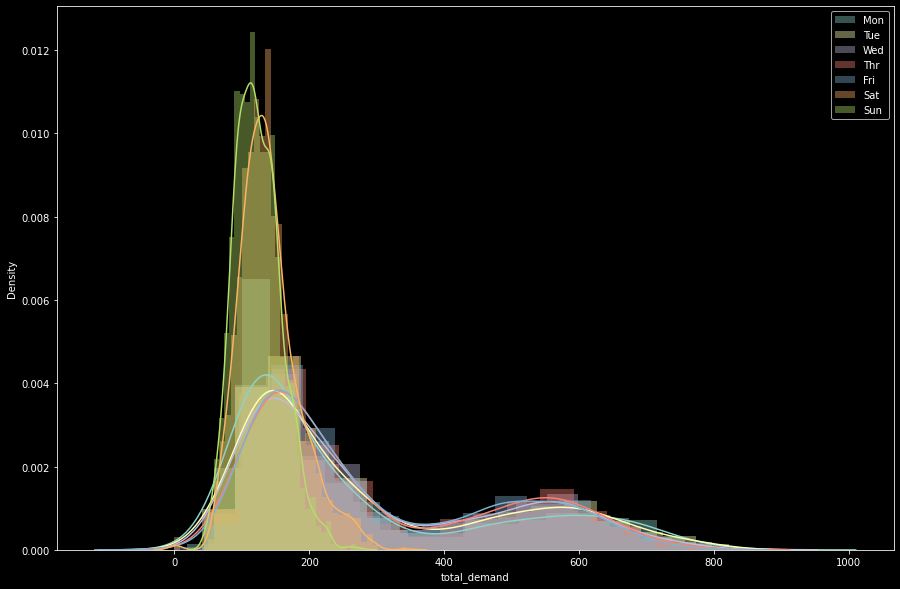

In [ ]:
# ▶ 요일 비교
sns.distplot(df[df['weekday']==0]['total_demand'], label='Mon');
sns.distplot(df[df['weekday']==1]['total_demand'], label='Tue');
sns.distplot(df[df['weekday']==2]['total_demand'], label='Wed');
sns.distplot(df[df['weekday']==3]['total_demand'], label='Thr');
sns.distplot(df[df['weekday']==4]['total_demand'], label='Fri');
sns.distplot(df[df['weekday']==5]['total_demand'], label='Sat');
sns.distplot(df[df['weekday']==6]['total_demand'], label='Sun');
plt.legend()
plt.gcf().set_size_inches(15, 10)

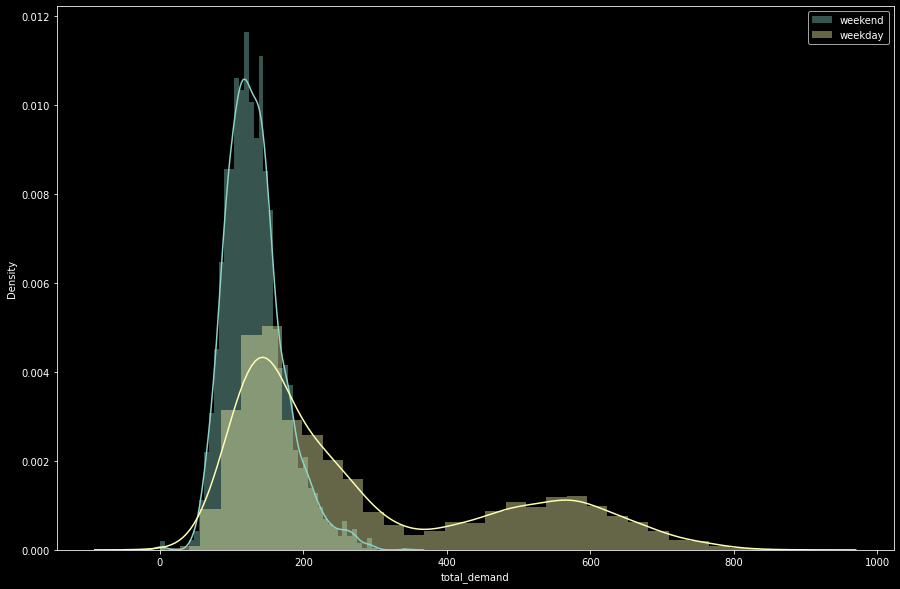

In [ ]:
# ▶ 평일 주말 비교
sns.distplot(df[df['workingday']==0]['total_demand'], label='weekend');
sns.distplot(df[df['workingday']==1]['total_demand'], label='weekday'); 
plt.legend()
plt.gcf().set_size_inches(15, 10)
# 평일은 봉우리가 2개. 지금 1시간단위 데이터이므로, 주중은 시간대에 따라 사용량이 크게 두 그룹으로 나뉘는 것으로 보임.

### · 주말, 주중 peak time 분석
---

In [ ]:
df.head()

,Date,total_demand,weekday,workingday
0,2018-07-01 00:00:00,176.261667,6,0
1,2018-07-01 01:00:00,177.300000,6,0
2,2018-07-01 02:00:00,177.048833,6,0
3,2018-07-01 03:00:00,175.129167,6,0
4,2018-07-01 04:00:00,183.175000,6,0


In [ ]:
# ▶ 주중, 주말 데이터 분할
df_weekday = df[df['workingday'] == 1]
df_weekend = df[df['workingday'] == 0]

len(df_weekday), len(df_weekend)

(9408, 3768)

In [ ]:
df_weekday = df_weekday[['Date', 'total_demand']]
df_weekend = df_weekend[['Date', 'total_demand']]

In [ ]:
df_weekday['total_demand'].describe(), df_weekend['total_demand'].describe() 

(count    9408.000000
 mean      285.379718
 std       188.249323
 min         0.000000
 25%       140.788333
 50%       206.049500
 75%       446.556125
 max       879.319167
 Name: total_demand, dtype: float64, count    3768.000000
 mean      132.099616
 std        40.802913
 min         0.000000
 25%       103.849875
 50%       127.354750
 75%       152.914083
 max       344.095667
 Name: total_demand, dtype: float64)

### └ Weekday

In [ ]:
df_temp = df_weekday.reset_index(drop=True).copy()
df_temp['date'] = df_temp['Date'].dt.date    
df_temp['hour'] = df_temp['Date'].dt.hour
df_temp

,Date,total_demand,date,hour
0,2018-07-02 00:00:00,165.985333,2018-07-02,0
1,2018-07-02 01:00:00,161.674667,2018-07-02,1
2,2018-07-02 02:00:00,159.642667,2018-07-02,2
3,2018-07-02 03:00:00,161.676333,2018-07-02,3
4,2018-07-02 04:00:00,175.787333,2018-07-02,4
...,...,...,...,...
9403,2019-12-31 19:00:00,120.144500,2019-12-31,19
9404,2019-12-31 20:00:00,124.547667,2019-12-31,20
9405,2019-12-31 21:00:00,104.895333,2019-12-31,21
9406,2019-12-31 22:00:00,95.204167,2019-12-31,22


In [ ]:
# ▶ 사용 패턴 분석을 위해 pivot table 활용
df_temp = df_weekday.reset_index(drop=True).copy()
df_temp['date'] = df_temp['Date'].dt.date    
df_temp['hour'] = df_temp['Date'].dt.hour
df_temp_pivot = df_temp.pivot_table(index='hour', columns='date', values='total_demand')
df_temp_pivot.head(5)

date,2018-07-02,2018-07-03,2018-07-04,2018-07-05,2018-07-06,2018-07-09,2018-07-10,2018-07-11,2018-07-12,2018-07-13,2018-07-16,2018-07-17,2018-07-18,2018-07-19,2018-07-20,2018-07-23,2018-07-24,2018-07-25,2018-07-26,2018-07-27,2018-07-30,2018-07-31,2018-08-01,2018-08-02,2018-08-03,2018-08-06,2018-08-07,2018-08-08,2018-08-09,2018-08-10,2018-08-13,2018-08-14,2018-08-15,2018-08-16,2018-08-17,2018-08-20,2018-08-21,2018-08-22,2018-08-23,2018-08-24,2018-08-27,2018-08-28,2018-08-29,2018-08-30,2018-08-31,2018-09-03,2018-09-04,2018-09-05,2018-09-06,2018-09-07,...,2019-10-23,2019-10-24,2019-10-25,2019-10-28,2019-10-29,2019-10-30,2019-10-31,2019-11-01,2019-11-04,2019-11-05,2019-11-06,2019-11-07,2019-11-08,2019-11-11,2019-11-12,2019-11-13,2019-11-14,2019-11-15,2019-11-18,2019-11-19,2019-11-20,2019-11-21,2019-11-22,2019-11-25,2019-11-26,2019-11-27,2019-11-28,2019-11-29,2019-12-02,2019-12-03,2019-12-04,2019-12-05,2019-12-06,2019-12-09,2019-12-10,2019-12-11,2019-12-12,2019-12-13,2019-12-16,2019-12-17,2019-12-18,2019-12-19,2019-12-20,2019-12-23,2019-12-24,2019-12-25,2019-12-26,2019-12-27,2019-12-30,2019-12-31
hour,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,165.985333,131.899000,151.461667,141.166833,167.399833,140.007667,121.010667,123.411333,142.624667,156.394333,83.575000,151.423000,104.509500,125.621000,146.721833,122.806833,158.990667,125.614167,190.626333,150.542667,180.232000,131.202500,171.845000,176.112667,146.618500,177.550000,153.220000,163.270833,151.025000,204.192833,167.943333,137.458000,164.800833,194.817000,231.351667,141.556833,180.451667,186.524667,169.512833,153.427667,105.859833,150.235667,113.062833,149.146500,104.390167,129.342000,118.728500,110.714333,118.556500,125.448000,...,126.943167,139.421333,140.771833,140.059333,139.122667,96.110333,120.189167,135.894500,123.340333,139.413333,180.499667,90.501833,110.387500,78.087333,144.680167,105.386000,144.627833,141.405167,112.191167,112.127333,100.569500,129.877833,117.212167,96.942333,87.603167,83.837333,83.474667,131.290500,100.597500,138.166167,101.663000,89.364667,118.135167,104.041333,78.414167,77.881333,104.450167,82.194000,115.944167,137.644500,72.199333,117.439833,149.476500,139.247833,86.558333,109.984833,137.489667,126.705667,118.726667,92.033167
1,161.674667,108.551333,150.612167,138.617000,167.501000,139.839833,119.471167,123.094500,142.030000,148.799167,84.547667,146.478000,103.142500,123.801667,146.342667,122.702500,159.769833,126.414833,163.386667,151.080500,178.390167,129.882500,170.964667,152.226500,136.771667,176.072500,156.500167,161.386333,150.632667,199.099167,170.530667,133.707333,163.564333,192.651833,241.282667,137.932167,178.955167,186.244500,168.038333,146.961333,106.296500,148.790833,112.040000,143.908167,103.663000,130.531000,100.043667,110.549833,118.991833,104.601000,...,127.571000,135.530667,140.358833,138.066167,140.162833,82.639500,103.714000,137.681500,127.347000,137.782667,169.364333,90.443833,92.176000,82.703500,140.199167,103.533500,146.734667,140.498833,114.338000,111.023500,100.823167,143.911833,120.083500,95.916667,90.549333,84.548000,83.081167,132.694167,102.983167,137.908333,100.644000,88.543167,117.937500,100.583000,64.963167,70.997500,103.523833,80.545667,117.051500,131.396000,75.069167,114.824500,150.325000,143.120833,75.298667,107.026667,127.115167,129.223333,120.385667,95.978000
2,159.642667,107.407500,153.343333,138.730333,167.161667,138.502333,118.479000,123.527833,141.195833,149.541500,85.148000,143.936667,104.334167,123.024667,147.209500,122.232833,164.664167,126.647333,167.328000,149.696167,177.402333,124.692500,169.149000,151.851333,135.219833,174.910500,154.885167,163.271333,148.888333,197.372500,171.696000,137.399667,162.418167,191.631333,241.634667,139.462833,178.297833,170.394833,163.958667,146.056333,103.687833,147.032167,112.393167,145.004333,103.860667,139.096000,102.313500,110.768667,118.884333,103.452500,...,103.399667,131.535167,141.310667,135.020333,141.3

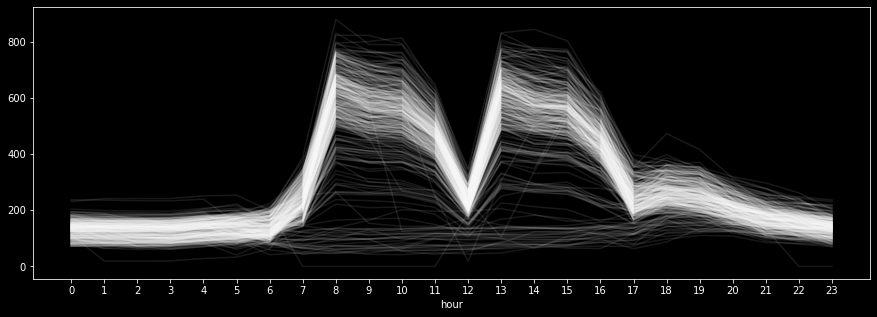

In [ ]:
plt.style.use(['dark_background'])
df_temp_pivot.plot(figsize=(15,5),color='white',alpha=0.1,legend=False);
plt.xticks(range(0,24));

* 주중에는 8-9시, 13-14시경에 각각 피크타임으로 관찰됨.
> 해당 시간대에는 사용 전력량이 매우 높은 경우가 존재하며, 해당 건에 대해 전력사용량을 최적화하거나 limit을 줄 경우 효율성이 높아질 것으로 기대

### └ Weekend

In [ ]:
# ▶ 사용 패턴 분석을 위해 pivot table 활용
df_temp = df_weekend.reset_index(drop=True).copy()
df_temp['date'] = df_temp['Date'].dt.date    
df_temp['hour'] = df_temp['Date'].dt.hour
df_temp_pivot = df_temp.pivot_table(index='hour', columns='date', values='total_demand')
df_temp_pivot.head(5)

date,2018-07-01,2018-07-07,2018-07-08,2018-07-14,2018-07-15,2018-07-21,2018-07-22,2018-07-28,2018-07-29,2018-08-04,2018-08-05,2018-08-11,2018-08-12,2018-08-18,2018-08-19,2018-08-25,2018-08-26,2018-09-01,2018-09-02,2018-09-08,2018-09-09,2018-09-15,2018-09-16,2018-09-22,2018-09-23,2018-09-29,2018-09-30,2018-10-06,2018-10-07,2018-10-13,2018-10-14,2018-10-20,2018-10-21,2018-10-27,2018-10-28,2018-11-03,2018-11-04,2018-11-10,2018-11-11,2018-11-17,2018-11-18,2018-11-24,2018-11-25,2018-12-01,2018-12-02,2018-12-08,2018-12-09,2018-12-15,2018-12-16,2018-12-22,...,2019-07-13,2019-07-14,2019-07-20,2019-07-21,2019-07-27,2019-07-28,2019-08-03,2019-08-04,2019-08-10,2019-08-11,2019-08-17,2019-08-18,2019-08-24,2019-08-25,2019-08-31,2019-09-01,2019-09-07,2019-09-08,2019-09-14,2019-09-15,2019-09-21,2019-09-22,2019-09-28,2019-09-29,2019-10-05,2019-10-06,2019-10-12,2019-10-13,2019-10-19,2019-10-20,2019-10-26,2019-10-27,2019-11-02,2019-11-03,2019-11-09,2019-11-10,2019-11-16,2019-11-17,2019-11-23,2019-11-24,2019-11-30,2019-12-01,2019-12-07,2019-12-08,2019-12-14,2019-12-15,2019-12-21,2019-12-22,2019-12-28,2019-12-29
hour,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,176.261667,183.5755,152.437833,131.714000,118.678167,134.769667,123.540667,139.7420,172.895500,207.3800,207.968000,218.697500,156.811000,195.737667,142.667167,138.152833,110.300167,135.267000,138.199667,123.763667,109.360500,88.051667,102.419000,135.825000,146.258333,124.800167,99.579333,155.959333,152.022167,82.691167,89.858833,135.968833,125.376333,151.480500,133.998500,161.074500,147.609500,86.453333,95.996000,147.238667,144.444833,138.015167,117.651000,151.794833,138.054833,140.876167,150.435500,122.840833,110.823833,82.904167,...,0.000000,106.805500,139.242333,144.643500,151.045000,106.000167,102.985667,80.101167,122.595000,134.519500,127.452833,141.139167,130.124167,138.925167,134.552167,157.101167,158.072500,126.503500,137.012500,78.347833,135.585500,98.065167,108.393000,105.689833,86.745000,71.677167,146.351500,136.228333,164.606833,120.317000,135.597667,126.252833,134.359833,133.932500,97.320667,104.150833,117.498333,118.219500,104.290333,82.580167,117.329000,106.029167,126.837000,108.465667,78.522167,104.850167,111.842167,84.520500,127.508167,136.562500
1,177.300000,182.4065,147.046000,107.378333,119.999333,134.711000,123.246500,140.4690,168.073000,208.1165,208.049667,215.978333,156.738667,196.001167,143.518833,137.564500,111.185667,137.016000,137.121167,123.348667,107.316500,89.304500,102.034667,134.914667,143.551500,125.115333,103.899833,150.116167,152.156000,84.149667,83.027833,120.690000,127.693167,155.512167,139.387333,156.738000,147.748833,89.365833,96.553333,144.296167,143.839167,102.333167,102.720667,148.965500,137.999333,140.179333,148.401500,122.751333,109.869833,82.050500,...,0.000000,102.426167,143.067167,141.828833,149.460833,88.320500,94.622333,81.427500,120.260167,136.940167,124.603333,140.157000,111.210500,136.671333,139.133500,141.182667,158.134000,128.268333,135.643667,81.285833,135.860667,100.789833,109.670000,105.501833,72.295000,75.222500,146.351167,137.444167,147.877333,120.547167,136.499667,123.266500,130.570500,135.314667,91.905500,106.801667,119.695167,120.526167,99.176500,85.799000,114.664667,117.630000,118.722500,108.857500,76.182333,106.252500,111.102500,81.558333,130.312500,140.172333
2,177.048833,180.1735,145.518333,109.976167,73.414833,134.337500,123.306667,139.8640,165.240333,205.8855,203.118333,214.078000,156.286833,197.829667,147.732667,137.645167,108.587167,135.956667,137.326667,122.699000,107.402333,80.911833,97.290833,136.241500,145.928500,124.270667,104.750500,150.570500,154.086833,87.816500,85.666833,119.182000,111.340333,153.475667,140.356000,156.121833,153.082833,91.541500,97.668500,144.217667,142.737667,122.621000,104.823500,151.365833,138.996833,141.094500,150.173500,127.349667,107.907500,86.959000,...,4.638500,102.704167,142.140000,141.000333,147.848167,89.404667,90.329333,78.2135

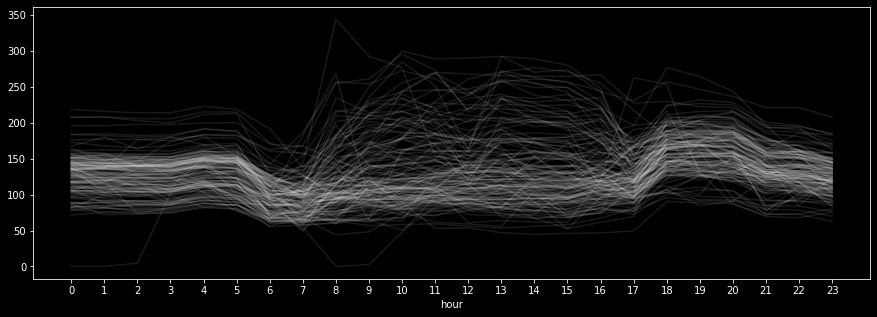

In [ ]:
plt.style.use(['dark_background'])
df_temp_pivot.plot(figsize=(15,5),color='white',alpha=0.1,legend=False);
plt.xticks(range(0,24));

* 주말은 특별한 피크타임이 존재하지 않으나, 낮시간대에 거의 평일만큼 사용량이 높았던 날도 분명히 있음. (흐리게 보이는 선)  
얘네가 이상케이스일 것으로 보임. 탐지할 필요가 있음.


(+) 저렇게 모든 날짜/시간에 대한 선을 그렸을 때 장점
> 만약 시간대별 일평균 수치를 구했을 경우에는, 일별 차이가 퉁쳐지기 때문에 위 그래프처럼 이상치에 해당하는 것들을 눈으로 확인하기 어려움. 위에처럼 그렸기 때문에 흐린 선들을 이상 케이스로 확인할 수 있는 것이다

## **🥇Session 3**  
**┗ 이상탐지 모델링**  
---

### · Weekday(주중) 전력사용 이상탐지
---


In [89]:
df_weekday.head(5)

,Date,total_demand
24,2018-07-02 00:00:00,165.985333
25,2018-07-02 01:00:00,161.674667
26,2018-07-02 02:00:00,159.642667
27,2018-07-02 03:00:00,161.676333
28,2018-07-02 04:00:00,175.787333


In [132]:
# ▶ 사용 패턴 분석을 위해 pivot table 활용
df_temp = df_weekday.reset_index(drop=True).copy()
df_temp['date'] = df_temp['Date'].dt.date    
df_temp['hour'] = df_temp['Date'].dt.hour
df_temp_pivot = df_temp.pivot_table(index='hour', columns='date', values='total_demand')
df_temp_pivot.head(5)

date,2018-07-02,2018-07-03,2018-07-04,2018-07-05,2018-07-06,2018-07-09,2018-07-10,2018-07-11,2018-07-12,2018-07-13,2018-07-16,2018-07-17,2018-07-18,2018-07-19,2018-07-20,2018-07-23,2018-07-24,2018-07-25,2018-07-26,2018-07-27,2018-07-30,2018-07-31,2018-08-01,2018-08-02,2018-08-03,2018-08-06,2018-08-07,2018-08-08,2018-08-09,2018-08-10,2018-08-13,2018-08-14,2018-08-15,2018-08-16,2018-08-17,2018-08-20,2018-08-21,2018-08-22,2018-08-23,2018-08-24,2018-08-27,2018-08-28,2018-08-29,2018-08-30,2018-08-31,2018-09-03,2018-09-04,2018-09-05,2018-09-06,2018-09-07,...,2019-10-23,2019-10-24,2019-10-25,2019-10-28,2019-10-29,2019-10-30,2019-10-31,2019-11-01,2019-11-04,2019-11-05,2019-11-06,2019-11-07,2019-11-08,2019-11-11,2019-11-12,2019-11-13,2019-11-14,2019-11-15,2019-11-18,2019-11-19,2019-11-20,2019-11-21,2019-11-22,2019-11-25,2019-11-26,2019-11-27,2019-11-28,2019-11-29,2019-12-02,2019-12-03,2019-12-04,2019-12-05,2019-12-06,2019-12-09,2019-12-10,2019-12-11,2019-12-12,2019-12-13,2019-12-16,2019-12-17,2019-12-18,2019-12-19,2019-12-20,2019-12-23,2019-12-24,2019-12-25,2019-12-26,2019-12-27,2019-12-30,2019-12-31
hour,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,165.985333,131.899000,151.461667,141.166833,167.399833,140.007667,121.010667,123.411333,142.624667,156.394333,83.575000,151.423000,104.509500,125.621000,146.721833,122.806833,158.990667,125.614167,190.626333,150.542667,180.232000,131.202500,171.845000,176.112667,146.618500,177.550000,153.220000,163.270833,151.025000,204.192833,167.943333,137.458000,164.800833,194.817000,231.351667,141.556833,180.451667,186.524667,169.512833,153.427667,105.859833,150.235667,113.062833,149.146500,104.390167,129.342000,118.728500,110.714333,118.556500,125.448000,...,126.943167,139.421333,140.771833,140.059333,139.122667,96.110333,120.189167,135.894500,123.340333,139.413333,180.499667,90.501833,110.387500,78.087333,144.680167,105.386000,144.627833,141.405167,112.191167,112.127333,100.569500,129.877833,117.212167,96.942333,87.603167,83.837333,83.474667,131.290500,100.597500,138.166167,101.663000,89.364667,118.135167,104.041333,78.414167,77.881333,104.450167,82.194000,115.944167,137.644500,72.199333,117.439833,149.476500,139.247833,86.558333,109.984833,137.489667,126.705667,118.726667,92.033167
1,161.674667,108.551333,150.612167,138.617000,167.501000,139.839833,119.471167,123.094500,142.030000,148.799167,84.547667,146.478000,103.142500,123.801667,146.342667,122.702500,159.769833,126.414833,163.386667,151.080500,178.390167,129.882500,170.964667,152.226500,136.771667,176.072500,156.500167,161.386333,150.632667,199.099167,170.530667,133.707333,163.564333,192.651833,241.282667,137.932167,178.955167,186.244500,168.038333,146.961333,106.296500,148.790833,112.040000,143.908167,103.663000,130.531000,100.043667,110.549833,118.991833,104.601000,...,127.571000,135.530667,140.358833,138.066167,140.162833,82.639500,103.714000,137.681500,127.347000,137.782667,169.364333,90.443833,92.176000,82.703500,140.199167,103.533500,146.734667,140.498833,114.338000,111.023500,100.823167,143.911833,120.083500,95.916667,90.549333,84.548000,83.081167,132.694167,102.983167,137.908333,100.644000,88.543167,117.937500,100.583000,64.963167,70.997500,103.523833,80.545667,117.051500,131.396000,75.069167,114.824500,150.325000,143.120833,75.298667,107.026667,127.115167,129.223333,120.385667,95.978000
2,159.642667,107.407500,153.343333,138.730333,167.161667,138.502333,118.479000,123.527833,141.195833,149.541500,85.148000,143.936667,104.334167,123.024667,147.209500,122.232833,164.664167,126.647333,167.328000,149.696167,177.402333,124.692500,169.149000,151.851333,135.219833,174.910500,154.885167,163.271333,148.888333,197.372500,171.696000,137.399667,162.418167,191.631333,241.634667,139.462833,178.297833,170.394833,163.958667,146.056333,103.687833,147.032167,112.393167,145.004333,103.860667,139.096000,102.313500,110.768667,118.884333,103.452500,...,103.399667,131.535167,141.310667,135.020333,141.3

* 3-Sigma rule을 사용해 이상치 탐지
- 왜? 전반적으로 시간대별 전력사용량 패턴이 일정하게 나타남.
- 다수의 정상적인 패턴이 존재하며, 거기서 너무 크게 벗어난 애들을 찾아내면 되기 떄문에   
복잡한 방식보다는 명확하고 심플한 방법을 사용하는 것도 방법.

In [ ]:
# ▶ UB, LB 계산을 위해 평균 및 표준편차 구하기 
df_temp_pivot['mean'] =  df_temp_pivot.apply(np.mean, axis=1)
df_temp_pivot['std'] = df_temp_pivot.apply(np.std, axis=1)
# df_temp_pivot[['mean', 'std']].head(5)
df_temp_pivot.head()

date,2018-07-02,2018-07-03,2018-07-04,2018-07-05,2018-07-06,2018-07-09,2018-07-10,2018-07-11,2018-07-12,2018-07-13,2018-07-16,2018-07-17,2018-07-18,2018-07-19,2018-07-20,2018-07-23,2018-07-24,2018-07-25,2018-07-26,2018-07-27,2018-07-30,2018-07-31,2018-08-01,2018-08-02,2018-08-03,2018-08-06,2018-08-07,2018-08-08,2018-08-09,2018-08-10,2018-08-13,2018-08-14,2018-08-15,2018-08-16,2018-08-17,2018-08-20,2018-08-21,2018-08-22,2018-08-23,2018-08-24,2018-08-27,2018-08-28,2018-08-29,2018-08-30,2018-08-31,2018-09-03,2018-09-04,2018-09-05,2018-09-06,2018-09-07,...,2019-10-25,2019-10-28,2019-10-29,2019-10-30,2019-10-31,2019-11-01,2019-11-04,2019-11-05,2019-11-06,2019-11-07,2019-11-08,2019-11-11,2019-11-12,2019-11-13,2019-11-14,2019-11-15,2019-11-18,2019-11-19,2019-11-20,2019-11-21,2019-11-22,2019-11-25,2019-11-26,2019-11-27,2019-11-28,2019-11-29,2019-12-02,2019-12-03,2019-12-04,2019-12-05,2019-12-06,2019-12-09,2019-12-10,2019-12-11,2019-12-12,2019-12-13,2019-12-16,2019-12-17,2019-12-18,2019-12-19,2019-12-20,2019-12-23,2019-12-24,2019-12-25,2019-12-26,2019-12-27,2019-12-30,2019-12-31,mean,std
hour,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,165.985333,131.899000,151.461667,141.166833,167.399833,140.007667,121.010667,123.411333,142.624667,156.394333,83.575000,151.423000,104.509500,125.621000,146.721833,122.806833,158.990667,125.614167,190.626333,150.542667,180.232000,131.202500,171.845000,176.112667,146.618500,177.550000,153.220000,163.270833,151.025000,204.192833,167.943333,137.458000,164.800833,194.817000,231.351667,141.556833,180.451667,186.524667,169.512833,153.427667,105.859833,150.235667,113.062833,149.146500,104.390167,129.342000,118.728500,110.714333,118.556500,125.448000,...,140.771833,140.059333,139.122667,96.110333,120.189167,135.894500,123.340333,139.413333,180.499667,90.501833,110.387500,78.087333,144.680167,105.386000,144.627833,141.405167,112.191167,112.127333,100.569500,129.877833,117.212167,96.942333,87.603167,83.837333,83.474667,131.290500,100.597500,138.166167,101.663000,89.364667,118.135167,104.041333,78.414167,77.881333,104.450167,82.194000,115.944167,137.644500,72.199333,117.439833,149.476500,139.247833,86.558333,109.984833,137.489667,126.705667,118.726667,92.033167,131.331907,28.409178
1,161.674667,108.551333,150.612167,138.617000,167.501000,139.839833,119.471167,123.094500,142.030000,148.799167,84.547667,146.478000,103.142500,123.801667,146.342667,122.702500,159.769833,126.414833,163.386667,151.080500,178.390167,129.882500,170.964667,152.226500,136.771667,176.072500,156.500167,161.386333,150.632667,199.099167,170.530667,133.707333,163.564333,192.651833,241.282667,137.932167,178.955167,186.244500,168.038333,146.961333,106.296500,148.790833,112.040000,143.908167,103.663000,130.531000,100.043667,110.549833,118.991833,104.601000,...,140.358833,138.066167,140.162833,82.639500,103.714000,137.681500,127.347000,137.782667,169.364333,90.443833,92.176000,82.703500,140.199167,103.533500,146.734667,140.498833,114.338000,111.023500,100.823167,143.911833,120.083500,95.916667,90.549333,84.548000,83.081167,132.694167,102.983167,137.908333,100.644000,88.543167,117.937500,100.583000,64.963167,70.997500,103.523833,80.545667,117.051500,131.396000,75.069167,114.824500,150.325000,143.120833,75.298667,107.026667,127.115167,129.223333,120.385667,95.978000,128.410206,29.269964
2,159.642667,107.407500,153.343333,138.730333,167.161667,138.502333,118.479000,123.527833,141.195833,149.541500,85.148000,143.936667,104.334167,123.024667,147.209500,122.232833,164.664167,126.647333,167.328000,149.696167,177.402333,124.692500,169.149000,151.851333,135.219833,174.910500,154.885167,163.271333,148.888333,197.372500,171.696000,137.399667,162.418167,191.631333,241.634667,139.462833,178.297833,170.394833,163.958667,146.056333,103.687833,147.032167,112.393167,145.004333,103.860667,139.096000,102.313500,110.768667,118.884333,103.452500,...,141.310667,135.020333,141.317000,85.934667,73.648167,135.486833,

In [ ]:
# ▶ UB, LB (표준편차에 몇을 곱할지는 조정하면서 진행)
df_temp_pivot['UB'] = df_temp_pivot['mean'] + 3*df_temp_pivot['std']
df_temp_pivot['LB'] = df_temp_pivot['mean'] - 3*df_temp_pivot['std']

<Figure size 1728x864 with 0 Axes>

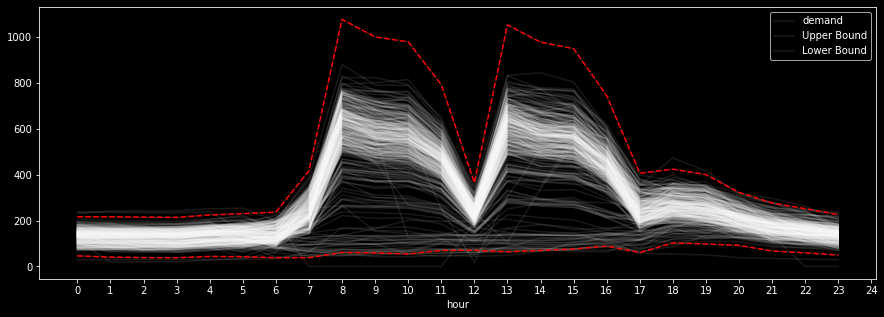

In [ ]:
plt.figure(figsize=(24,12));
df_temp_pivot.plot(figsize=(15,5),color='white',alpha=0.1,legend=False);
plt.plot(df_temp_pivot.index, df_temp_pivot['UB'], linestyle='--', color='red');
plt.plot(df_temp_pivot.index, df_temp_pivot['LB'] , linestyle='--', color='red');
plt.xticks(range(0,25));
plt.legend(['demand', 'Upper Bound', 'Lower Bound']);

In [ ]:
# ▶ UB, LB (표준편차에 3을 곱했을땐 bound가 너무 넓어 2로 조정함)
df_temp_pivot['UB'] = df_temp_pivot['mean'] + 2*df_temp_pivot['std']
df_temp_pivot['LB'] = df_temp_pivot['mean'] - 2*df_temp_pivot['std']

<Figure size 1728x864 with 0 Axes>

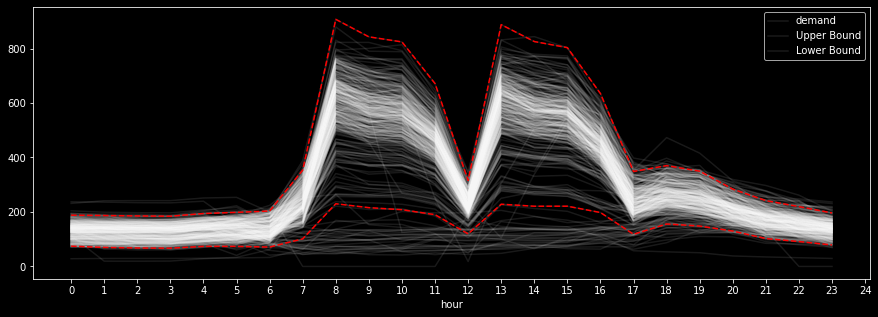

In [ ]:
plt.figure(figsize=(24,12));
df_temp_pivot.plot(figsize=(15,5),color='white',alpha=0.1,legend=False);
plt.plot(df_temp_pivot.index, df_temp_pivot['UB'], linestyle='--', color='red');
plt.plot(df_temp_pivot.index, df_temp_pivot['LB'] , linestyle='--', color='red');
plt.xticks(range(0,25));
plt.legend(['demand', 'Upper Bound', 'Lower Bound']);

In [ ]:
# ▶ transpose 정상 데이터 변환
df_trans = df_temp_pivot.transpose()
df_trans.head()

hour,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
date,,,,,,,,,,,,,,,,,,,,,,,,
2018-07-02,165.985333,161.674667,159.642667,161.676333,175.787333,170.425333,196.004333,388.554333,879.319167,790.151667,788.247000,623.208000,347.851667,830.949667,772.427500,680.769833,505.436167,262.390833,242.319833,226.239000,166.146000,144.235000,137.935000,131.790500
2018-07-03,131.899000,108.551333,107.407500,105.860000,125.858333,136.880167,175.991667,339.218167,732.867333,672.135000,617.890667,496.177333,257.852333,672.045833,616.441333,606.372000,470.374000,281.021667,361.238333,352.938833,254.252000,172.006167,154.113833,151.615833
2018-07-04,151.461667,150.612167,153.343333,153.721000,166.073167,167.860333,148.085667,345.777500,753.655333,618.404667,592.019167,464.300833,292.340167,700.819667,577.232667,582.802000,436.875333,231.310167,264.898667,249.956833,201.979167,189.537833,155.803000,140.610333
2018-07-05,141.166833,138.617000,138.730333,136.327667,147.561333,155.378500,161.575333,310.369500,682.235500,604.616667,603.597333,477.598167,261.235667,696.772833,584.519000,601.417000,453.814500,268.385167,327.930333,308.598833,212.896667,186.486000,215.566833,179.268167
2018-07-06,167.399833,167.501000,167.161667,163.560000,178.709167,181.884000,194.496500,331.265000,665.421333,587.234000,597.176500,472.711167,250.686167,648.317000,580.543833,565.802500,466.915333,353.154833,472.957500,415.926167,314.470000,277.834833,229.721000,209.454500


In [ ]:
# ▶ 0 hr Anomaly Detection (0시에 이상치가 발생했던 날짜를 조회)
df_trans[df_trans.loc[:,0] > df_trans.loc['UB',0]].index.astype(str)

Index(['2018-07-26', '2018-08-10', '2018-08-16', '2018-08-17', '2018-10-05',
       '2019-02-12', '2019-05-22'],
      dtype='object', name='date')

In [ ]:
# ▶ for 문
date_list = []

for i in df_trans.columns :
  ap = df_trans[df_trans.loc[:,i] > df_trans.loc['UB',i]].index.astype(str)
  date_list.extend(ap)

In [ ]:
date_list[0:5]

['2018-07-26', '2018-08-10', '2018-08-16', '2018-08-17', '2018-10-05']

In [ ]:
# ▶ 2018-08-16일이 24시간 중 10회가 이상 탐지 됨
from collections import Counter
print(Counter(date_list))

Counter({'2018-08-16': 10, '2018-10-05': 9, '2018-08-10': 8, '2018-08-09': 7, '2018-07-06': 7, '2018-08-17': 6, '2019-05-22': 5, '2018-08-21': 5, '2019-05-21': 4, '2018-08-03': 4, '2018-08-15': 4, '2018-09-12': 3, '2018-09-13': 3, '2018-09-25': 3, '2019-05-31': 3, '2019-07-04': 3, '2019-02-12': 2, '2019-01-10': 2, '2018-07-20': 2, '2018-07-02': 2, '2019-04-22': 2, '2019-04-30': 2, '2019-05-03': 2, '2019-05-02': 2, '2018-10-11': 2, '2019-02-11': 2, '2019-08-22': 2, '2018-07-26': 1, '2019-02-08': 1, '2018-07-13': 1, '2018-08-08': 1, '2019-02-14': 1, '2018-09-28': 1, '2019-06-04': 1, '2019-06-05': 1, '2019-08-20': 1, '2019-04-29': 1, '2018-07-23': 1, '2019-04-24': 1, '2019-05-01': 1, '2019-05-07': 1, '2019-05-16': 1, '2019-05-27': 1, '2019-05-28': 1, '2018-07-03': 1, '2018-07-24': 1, '2018-10-04': 1, '2019-05-29': 1, '2019-07-05': 1, '2018-07-12': 1, '2019-06-27': 1, '2018-07-25': 1})


In [ ]:
# ▶ 2018-08-16일 확인하기
df_train_reset = df_trans.reset_index()
df_train_reset['date'] = df_train_reset['date'].astype(str)
abnormal_date = df_train_reset[df_train_reset['date'] == '2018-08-16'].transpose()
abnormal_date = abnormal_date.drop(['date'], axis=0)
abnormal_date

,33
hour,
0,194.817
1,192.651833
2,191.631333
3,188.7805
4,203.7915
5,222.684333
6,162.2945
7,311.664833
8,619.444667


<Figure size 1728x864 with 0 Axes>

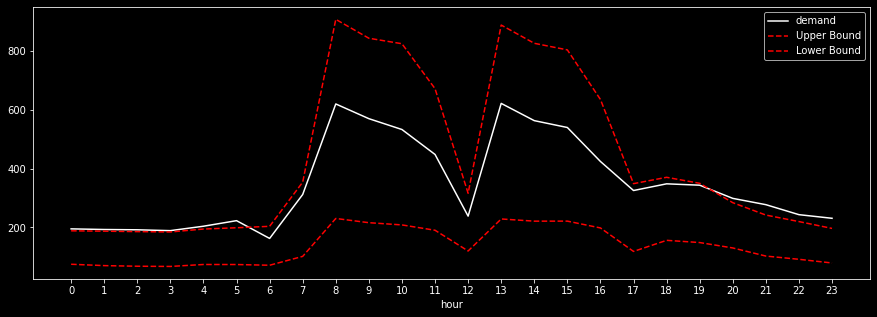

In [ ]:
plt.figure(figsize=(24,12)); # 언제 bound를 넘었는지 확인
abnormal_date.plot(figsize=(15,5),color='white',legend=False);
plt.plot(df_temp_pivot.index, df_temp_pivot['UB'], linestyle='--', color='red');
plt.plot(df_temp_pivot.index, df_temp_pivot['LB'] , linestyle='--', color='red');
plt.xticks(range(0,24));
plt.legend(['demand', 'Upper Bound', 'Lower Bound']);

* 왜 이 날 야간 및 새벽5시에 사용량이 높았는지 후속분석 필요

(+) 그런데, 엄밀히 말하면 3-sigma rule 적용하기 위해서는 정규성이 가정되어야 함 (사실 이게 큰 한계라고 했음)
- 시간대별 rule 적용중 >> 각 시간대의 전력소비량 분포가 정규성을 만족해야 함
- 과연 실제로 정규성을 충족할까?

In [134]:
# 정규성 검정 - Shapiro-Wilk Test
# (h0: 해당 데이터가 정규성을 충족한다.)
import numpy as np
from scipy.stats import shapiro

hour_list = sorted(df_temp['hour'].unique())

for hour in hour_list:
  tmp = df_temp[df_temp['hour']==hour]
  shapiro_test = shapiro(tmp['total_demand'])
  pvalue = shapiro_test.pvalue
  print(f'{hour}시 p-value = {pvalue}')

0시 p-value = 0.0015192428836598992
1시 p-value = 0.0002902723790612072
2시 p-value = 0.00023479438095819205
3시 p-value = 0.00011470166646176949
4시 p-value = 0.0007782406755723059
5시 p-value = 0.015954401344060898
6시 p-value = 0.00037063000490888953
7시 p-value = 1.4032818398845848e-05
8시 p-value = 8.746015199775003e-20
9시 p-value = 1.1298964567035462e-18
10시 p-value = 1.516078960563728e-18
11시 p-value = 4.347473115989358e-19
12시 p-value = 2.281187391761641e-12
13시 p-value = 1.3767113316601546e-19
14시 p-value = 1.5994388105767954e-18
15시 p-value = 5.363149578579438e-19
16시 p-value = 1.6165126456005024e-18
17시 p-value = 0.0031444551423192024
18시 p-value = 0.0023389323614537716
19시 p-value = 0.12928764522075653
20시 p-value = 0.03803810849785805
21시 p-value = 0.007551232818514109
22시 p-value = 0.00011444065603427589
23시 p-value = 0.0008386324043385684


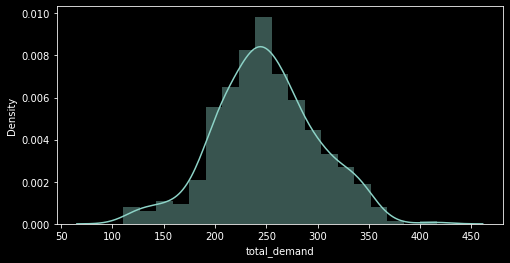

In [141]:
# 유일하게 정규성을 충족하는 19시의 데이터
h19 = df_temp[df_temp['hour']==19]

plt.figure(figsize=(8,4))
sns.distplot(h19['total_demand'])
plt.show()

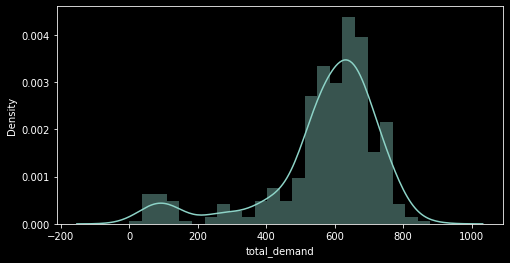

In [143]:
# 낮시간대 데이터들은 대부분 정규성을 충족하지 못함
h8 = df_temp[df_temp['hour']==8]

plt.figure(figsize=(8,4))
sns.distplot(h8['total_demand'])
plt.show()

* 19시를 제외하고는 귀무가설 기각 >> 정규성을 충족하지 않는다.
그럼에도 3sigma rule을 그냥 적용해도 되는지?
* 과연 이 방식으로 이상탐지를 하는게 적절한 방식인가?
* 실무에서는 어떻게 사용되는지 찾아보자

### · Weekend(주말) 전력사용 이상탐지
---


* 주중과 같은 방식으로 진행

In [ ]:
df_weekend.head()

,Date,total_demand
0,2018-07-01 00:00:00,176.261667
1,2018-07-01 01:00:00,177.300000
2,2018-07-01 02:00:00,177.048833
3,2018-07-01 03:00:00,175.129167
4,2018-07-01 04:00:00,183.175000


In [128]:
# df_weekend
df_temp = df_weekend.reset_index().copy()
df_temp['date'] = df_temp['Date'].dt.date    
df_temp['hour'] = df_temp['Date'].dt.hour
df_temp_pivot = df_temp.pivot_table(index='hour', columns='date', values='total_demand')
df_temp_pivot.head(5)

date,2018-07-01,2018-07-07,2018-07-08,2018-07-14,2018-07-15,2018-07-21,2018-07-22,2018-07-28,2018-07-29,2018-08-04,2018-08-05,2018-08-11,2018-08-12,2018-08-18,2018-08-19,2018-08-25,2018-08-26,2018-09-01,2018-09-02,2018-09-08,2018-09-09,2018-09-15,2018-09-16,2018-09-22,2018-09-23,2018-09-29,2018-09-30,2018-10-06,2018-10-07,2018-10-13,2018-10-14,2018-10-20,2018-10-21,2018-10-27,2018-10-28,2018-11-03,2018-11-04,2018-11-10,2018-11-11,2018-11-17,2018-11-18,2018-11-24,2018-11-25,2018-12-01,2018-12-02,2018-12-08,2018-12-09,2018-12-15,2018-12-16,2018-12-22,...,2019-07-13,2019-07-14,2019-07-20,2019-07-21,2019-07-27,2019-07-28,2019-08-03,2019-08-04,2019-08-10,2019-08-11,2019-08-17,2019-08-18,2019-08-24,2019-08-25,2019-08-31,2019-09-01,2019-09-07,2019-09-08,2019-09-14,2019-09-15,2019-09-21,2019-09-22,2019-09-28,2019-09-29,2019-10-05,2019-10-06,2019-10-12,2019-10-13,2019-10-19,2019-10-20,2019-10-26,2019-10-27,2019-11-02,2019-11-03,2019-11-09,2019-11-10,2019-11-16,2019-11-17,2019-11-23,2019-11-24,2019-11-30,2019-12-01,2019-12-07,2019-12-08,2019-12-14,2019-12-15,2019-12-21,2019-12-22,2019-12-28,2019-12-29
hour,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,176.261667,183.5755,152.437833,131.714000,118.678167,134.769667,123.540667,139.7420,172.895500,207.3800,207.968000,218.697500,156.811000,195.737667,142.667167,138.152833,110.300167,135.267000,138.199667,123.763667,109.360500,88.051667,102.419000,135.825000,146.258333,124.800167,99.579333,155.959333,152.022167,82.691167,89.858833,135.968833,125.376333,151.480500,133.998500,161.074500,147.609500,86.453333,95.996000,147.238667,144.444833,138.015167,117.651000,151.794833,138.054833,140.876167,150.435500,122.840833,110.823833,82.904167,...,0.000000,106.805500,139.242333,144.643500,151.045000,106.000167,102.985667,80.101167,122.595000,134.519500,127.452833,141.139167,130.124167,138.925167,134.552167,157.101167,158.072500,126.503500,137.012500,78.347833,135.585500,98.065167,108.393000,105.689833,86.745000,71.677167,146.351500,136.228333,164.606833,120.317000,135.597667,126.252833,134.359833,133.932500,97.320667,104.150833,117.498333,118.219500,104.290333,82.580167,117.329000,106.029167,126.837000,108.465667,78.522167,104.850167,111.842167,84.520500,127.508167,136.562500
1,177.300000,182.4065,147.046000,107.378333,119.999333,134.711000,123.246500,140.4690,168.073000,208.1165,208.049667,215.978333,156.738667,196.001167,143.518833,137.564500,111.185667,137.016000,137.121167,123.348667,107.316500,89.304500,102.034667,134.914667,143.551500,125.115333,103.899833,150.116167,152.156000,84.149667,83.027833,120.690000,127.693167,155.512167,139.387333,156.738000,147.748833,89.365833,96.553333,144.296167,143.839167,102.333167,102.720667,148.965500,137.999333,140.179333,148.401500,122.751333,109.869833,82.050500,...,0.000000,102.426167,143.067167,141.828833,149.460833,88.320500,94.622333,81.427500,120.260167,136.940167,124.603333,140.157000,111.210500,136.671333,139.133500,141.182667,158.134000,128.268333,135.643667,81.285833,135.860667,100.789833,109.670000,105.501833,72.295000,75.222500,146.351167,137.444167,147.877333,120.547167,136.499667,123.266500,130.570500,135.314667,91.905500,106.801667,119.695167,120.526167,99.176500,85.799000,114.664667,117.630000,118.722500,108.857500,76.182333,106.252500,111.102500,81.558333,130.312500,140.172333
2,177.048833,180.1735,145.518333,109.976167,73.414833,134.337500,123.306667,139.8640,165.240333,205.8855,203.118333,214.078000,156.286833,197.829667,147.732667,137.645167,108.587167,135.956667,137.326667,122.699000,107.402333,80.911833,97.290833,136.241500,145.928500,124.270667,104.750500,150.570500,154.086833,87.816500,85.666833,119.182000,111.340333,153.475667,140.356000,156.121833,153.082833,91.541500,97.668500,144.217667,142.737667,122.621000,104.823500,151.365833,138.996833,141.094500,150.173500,127.349667,107.907500,86.959000,...,4.638500,102.704167,142.140000,141.000333,147.848167,89.404667,90.329333,78.2135

In [129]:
# 정규성 검정 - Shapiro-Wilk Test
# (h0: 해당 데이터가 정규성을 충족한다.)
import numpy as np
from scipy.stats import shapiro

hour_list = sorted(df_temp['hour'].unique())

for hour in hour_list:
  tmp = df_temp[df_temp['hour']==hour]
  shapiro_test = shapiro(tmp['total_demand'])
  pvalue = shapiro_test.pvalue
  print(f'{hour}시 p-value = {pvalue}')

0시 p-value = 3.920450762961991e-05
1시 p-value = 6.900220614625141e-05
2시 p-value = 0.0004145907878410071
3시 p-value = 0.0017015303019434214
4시 p-value = 0.001892352825962007
5시 p-value = 0.0014052808983251452
6시 p-value = 0.00040034728590399027
7시 p-value = 5.8394634834257886e-05
8시 p-value = 1.2524931092272595e-09
9시 p-value = 1.1361347560523427e-06
10시 p-value = 8.720365762826532e-09
11시 p-value = 1.4728334107871888e-08
12시 p-value = 1.0877973011247377e-07
13시 p-value = 1.5942920583711384e-07
14시 p-value = 2.4428936740150675e-07
15시 p-value = 4.952427161697415e-07
16시 p-value = 2.5437830686314555e-07
17시 p-value = 1.1356256436556578e-05
18시 p-value = 0.02867427095770836
19시 p-value = 0.3355254530906677
20시 p-value = 0.6147443056106567
21시 p-value = 0.11884981393814087
22시 p-value = 0.36343079805374146
23시 p-value = 0.5331056118011475


In [ ]:
df_temp_pivot['mean'] =  df_temp_pivot.apply(np.mean, axis=1)
df_temp_pivot['std'] = df_temp_pivot.apply(np.std, axis=1)
df_temp_pivot[['mean', 'std']].head(5)

date,mean,std
hour,,
0,129.335487,27.792407
1,127.376036,27.980207
2,125.984939,28.159846
3,126.209162,26.959907
4,133.955066,27.121575


<Figure size 1728x864 with 0 Axes>

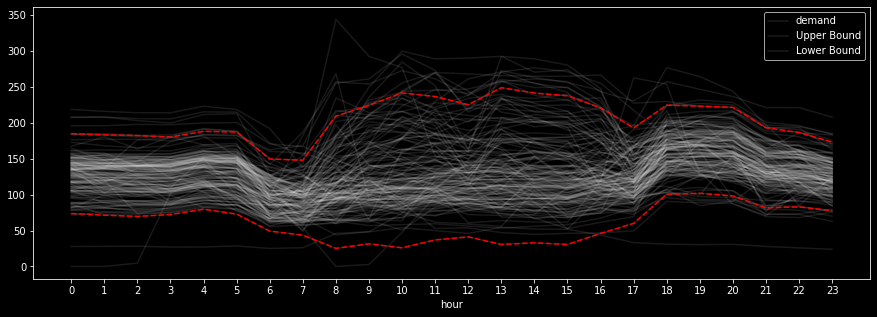

In [ ]:
df_temp_pivot['UB'] = df_temp_pivot['mean'] + 2*df_temp_pivot['std']
df_temp_pivot['LB'] = df_temp_pivot['mean'] - 2*df_temp_pivot['std']

plt.figure(figsize=(24,12));
df_temp_pivot.plot(figsize=(15,5),color='white',alpha=0.1,legend=False);
plt.plot(df_temp_pivot.index, df_temp_pivot['UB'], linestyle='--', color='red');
plt.plot(df_temp_pivot.index, df_temp_pivot['LB'] , linestyle='--', color='red');
plt.xticks(range(0,24));
plt.legend(['demand', 'Upper Bound', 'Lower Bound']);

In [ ]:
df_trans = df_temp_pivot.transpose()
df_trans.head()

hour,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
date,,,,,,,,,,,,,,,,,,,,,,,,
2018-07-01,176.261667,177.300000,177.048833,175.129167,183.175000,181.883667,160.375833,157.988667,142.767833,117.386000,118.581667,120.378000,123.815667,125.621000,125.465333,124.362667,136.078000,165.169000,188.052833,203.833000,215.054833,185.6340,180.671833,165.654667
2018-07-07,183.575500,182.406500,180.173500,180.999500,191.836000,188.013833,142.066667,187.002333,257.087833,254.040000,272.682500,261.266000,238.355500,270.565500,254.757333,248.647000,221.785833,156.989333,173.552333,176.255167,179.843333,176.7540,168.342833,146.343000
2018-07-08,152.437833,147.046000,145.518333,146.349500,156.714000,149.102000,117.651000,103.975167,100.827000,106.180667,113.984833,117.167667,121.729667,121.520667,121.693333,123.824833,161.735833,164.567833,184.599500,192.030667,191.702000,153.8390,151.763333,141.305000
2018-07-14,131.714000,107.378333,109.976167,108.467500,116.965167,96.870333,85.058833,89.727667,181.448333,196.903333,197.827500,202.368000,135.220333,131.488333,125.614833,140.341333,136.259833,121.065833,162.927500,171.304167,159.626000,138.6555,139.372667,129.932000
2018-07-15,118.678167,119.999333,73.414833,82.215000,92.500000,88.483667,85.390167,87.233667,95.005000,93.508333,109.978333,140.730000,130.622000,133.725000,141.560333,171.332667,158.700167,155.623667,177.117000,127.623833,126.165167,116.8995,116.349333,87.648000


In [ ]:
# for 문
date_list = []

for i in df_trans.columns :
  ap = df_trans[df_trans.loc[:,i] > df_trans.loc['UB',i]].index.astype(str)
  date_list.extend(ap)

In [ ]:
from collections import Counter
print(Counter(date_list))

Counter({'2018-08-04': 23, '2018-07-07': 13, '2019-05-04': 13, '2018-08-05': 11, '2018-08-11': 8, '2018-08-18': 8, '2018-07-21': 8, '2019-08-31': 7, '2019-07-20': 7, '2019-08-03': 7, '2019-05-05': 6, '2019-08-24': 6, '2018-09-08': 5, '2018-10-28': 5, '2019-07-06': 4, '2019-06-29': 4, '2018-10-07': 4, '2019-09-14': 3, '2019-07-27': 3, '2018-07-28': 3, '2018-07-01': 2, '2019-02-23': 2, '2019-07-13': 2, '2018-11-11': 2, '2019-05-25': 1, '2019-09-21': 1, '2018-07-22': 1, '2018-09-22': 1, '2018-09-23': 1, '2018-08-12': 1, '2019-03-03': 1})


In [ ]:
df_train_reset = df_trans.reset_index()
df_train_reset['date'] = df_train_reset['date'].astype(str)
abnormal_date = df_train_reset[df_train_reset['date'] == '2018-07-07'].transpose()
abnormal_date = abnormal_date.drop(['date'], axis=0)
abnormal_date

,1
hour,
0,183.5755
1,182.4065
2,180.1735
3,180.9995
4,191.836
5,188.013833
6,142.066667
7,187.002333
8,257.087833


<Figure size 1728x864 with 0 Axes>

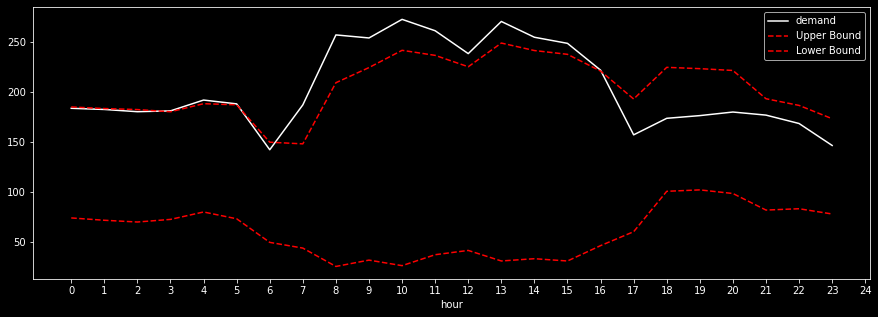

In [ ]:
plt.figure(figsize=(24,12));
abnormal_date.plot(figsize=(15,5),color='white',legend=False);
plt.plot(df_temp_pivot.index, df_temp_pivot['UB'], linestyle='--', color='red');
plt.plot(df_temp_pivot.index, df_temp_pivot['LB'] , linestyle='--', color='red');
plt.xticks(range(0,25));
plt.legend(['demand', 'Upper Bound', 'Lower Bound']);